## Final assignment: Research project involving implementation of a ~~GAN~~ variational laplace autoencoder benchmarked on fashion MNIST

In [1]:
import math
import VLAE
import os
from matplotlib import pyplot as plt
import numpy as np
import torch
from torch import nn, optim
from torch.distributions import Normal
from torch.nn import functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.utils import make_grid
from IPython.display import clear_output, display

In [25]:
latent_size = 25
batch_size = 100

data_path = os.path.join(os.path.expanduser('~'), '.torch', 'datasets', 'mnist')
train_data = datasets.FashionMNIST(data_path, train=True, download=True, transform=transforms.ToTensor())
test_data = datasets.FashionMNIST(data_path, train=False, transform=transforms.ToTensor())

train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True, drop_last=True, num_workers=4)
test_loader = DataLoader(test_data, batch_size=batch_size, num_workers=4)

In [26]:
dim = [1,28,28]

train = torch.stack([data for data, _ in
                        list(train_loader.dataset)], 0)
train = train.view(train.shape[0], -1)

mean = train.mean(0)
dataset_logvar = torch.log(torch.mean((train - mean)**2)).unsqueeze(0)

def preprocess(x):
    return x.view([-1, np.prod(dim)]) - mean

torch.Size([100, 784])
torch.Size([100, 784])
torch.Size([100, 784])
torch.Size([100, 784])
torch.Size([100, 784])
torch.Size([100, 784])
torch.Size([100, 784])
torch.Size([100, 784])
torch.Size([100, 784])
torch.Size([100, 784])
torch.Size([100, 784])
torch.Size([100, 784])
torch.Size([100, 784])
torch.Size([100, 784])
torch.Size([100, 784])
torch.Size([100, 784])
torch.Size([100, 784])
torch.Size([100, 784])
torch.Size([100, 784])
torch.Size([100, 784])
torch.Size([100, 784])
torch.Size([100, 784])
torch.Size([100, 784])
torch.Size([100, 784])
torch.Size([100, 784])
torch.Size([100, 784])
torch.Size([100, 784])
torch.Size([100, 784])
torch.Size([100, 784])


RuntimeError: cholesky_cpu: For batch 81: U(25,25) is zero, singular U.

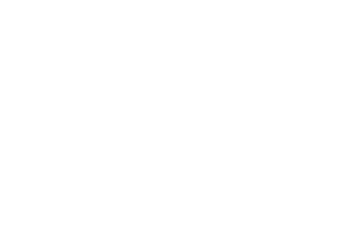

In [27]:
from timeit import time
plt.axis('off')

model = VLAE.VLAE(image_size=784, zdim=latent_size, hd_enc_dim=20, hd_dec_dim=20)
optimiser = optim.Adam(model.parameters(), lr=5e-3)
epochs = 10
#z_samples = torch.randn(64, latent_size)
#z_interp = torch.zeros(64, latent_size)
#grid_x, grid_y = torch.meshgrid([torch.linspace(-1.5, 1.5, 8), torch.linspace(-1.5, 1.5, 8)])
#z_interp[:, 0] = grid_y.contiguous().view(-1)
#z_interp[:, 1] = grid_x.contiguous().view(-1)
#black_bar = torch.zeros(3, 8 * 28, 10)

def train(model, optimiser):
    model.train()
    tloss = 0
    epoch_start_time = time.time()
    for i, (x, _) in enumerate(train_loader):
        optimiser.zero_grad()
        x = preprocess(x)
        print(x.shape)
        loss = model(x) 
        loss.backward() # elbo grad
        tloss += loss.item() * len(x)
        optimiser.step()
        
    duration = time.time() - epoch_start_time
    epoch_loss = train_loss / len(train_loader.dataset)
    
    return tloss
    
def test(model):
    model.eval()
    test_loss = 0
    
    with torch.no_grad():
        for i, (data, _) in enumerate(test_loader):
            #data = self.dataset.preprocess(data)

            test_loss += model(preprocess(data)).item() * len(data)

    test_loss /= len(test_loader.dataset)
    return test_loss


def initialize_params(model): # (He et al., 2015)
    for m in model.modules():
        if isinstance(m, nn.Linear):
            nn.init.kaiming_uniform_(m.weight, a=math.pow(2, 1.0/3), mode='fan_out')

    model.decoder.logvar.data = dataset_logvar

def sample(model):
    model.eval()
    with torch.no_grad():
        samples = make_grid(model.decode(z_samples), padding=0)
        interps = make_grid(model.decode(z_interp), padding=0)
        plt.imshow(np.transpose(torch.cat([samples, black_bar, interps], 2).numpy(), [1, 2, 0]))
        clear_output(wait=True)
        display(plt.gcf())

        

        
for _ in range(epochs):
    initialize_params(model)
    train(model, optimiser)
    #sample(model)
clear_output(wait=True)

In [ ]:
model(torch.rand(64, 784))